In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
raw_data = pd.read_csv("test_scores.csv",)
raw_data.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [3]:
f_data = raw_data.loc[:,~raw_data.columns.isin({"school","classroom","student_id"})].copy()
f_data.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,62.0,72.0
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,66.0,79.0
2,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0
3,Urban,Non-public,Standard,20.0,Female,Does not qualify,61.0,77.0
4,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0


In [4]:
for col in f_data.columns:
    if (f_data[col].dtype == "object"):
        f_data[col] = f_data[col].astype('category')


In [5]:
f_data.posttest.describe().to_frame()


,posttest
count,2133.000000
mean,67.102203
std,13.986789
min,32.000000
25%,56.000000
50%,68.000000
75%,77.000000
max,100.000000


In [6]:
g_bins = range(30,101,5)

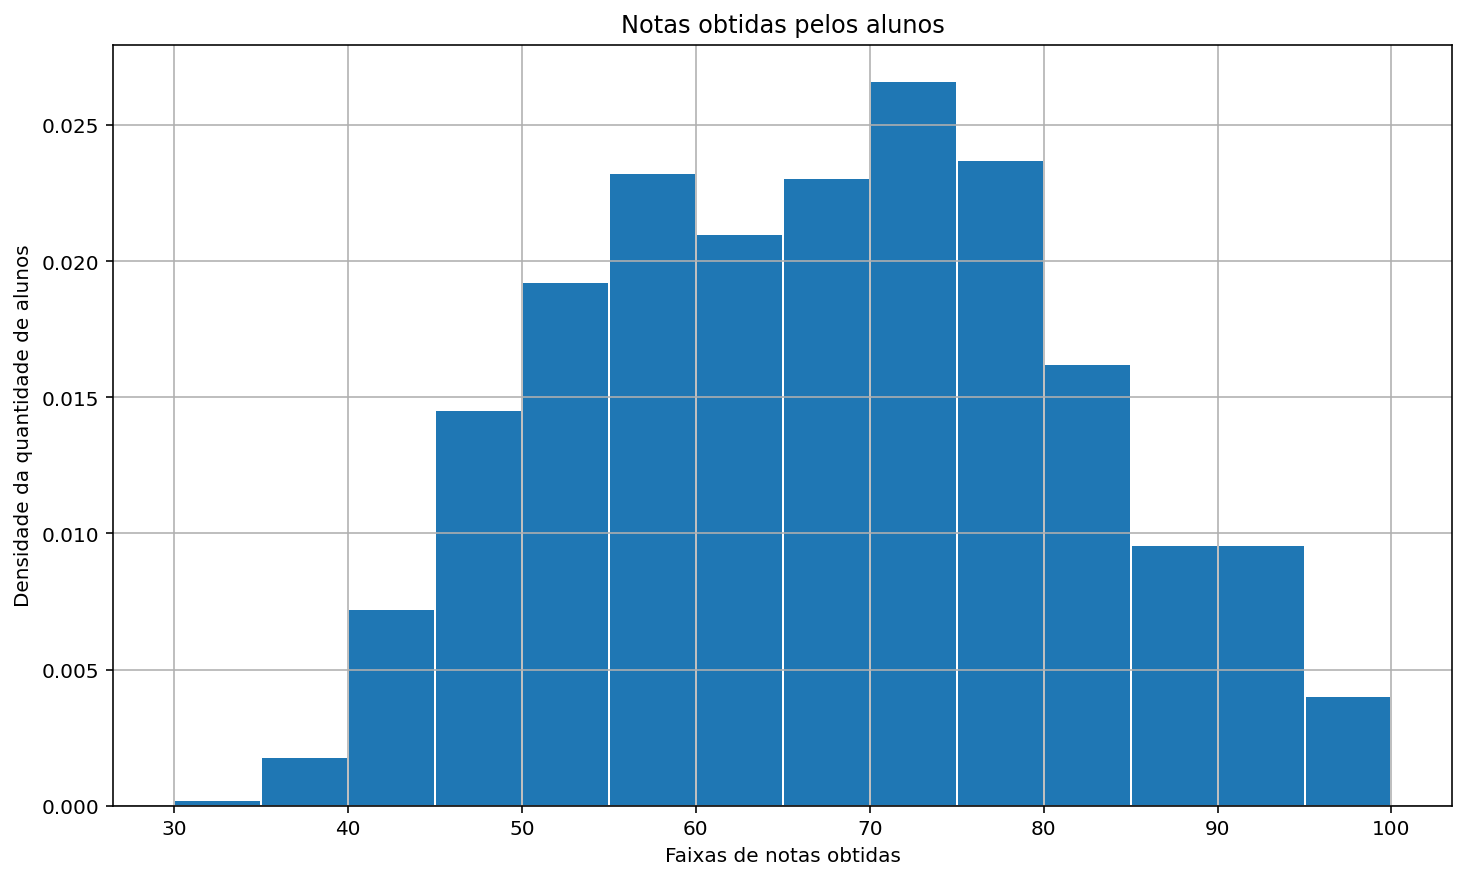

In [7]:
f_data.posttest.hist(edgecolor = 'white',bins = g_bins, density = True)
plt.title('Notas obtidas pelos alunos')
plt.ylabel('Densidade da quantidade de alunos')
plt.xlabel('Faixas de notas obtidas')
plt.show()

['school_type', 'teaching_method', 'gender', 'lunch']


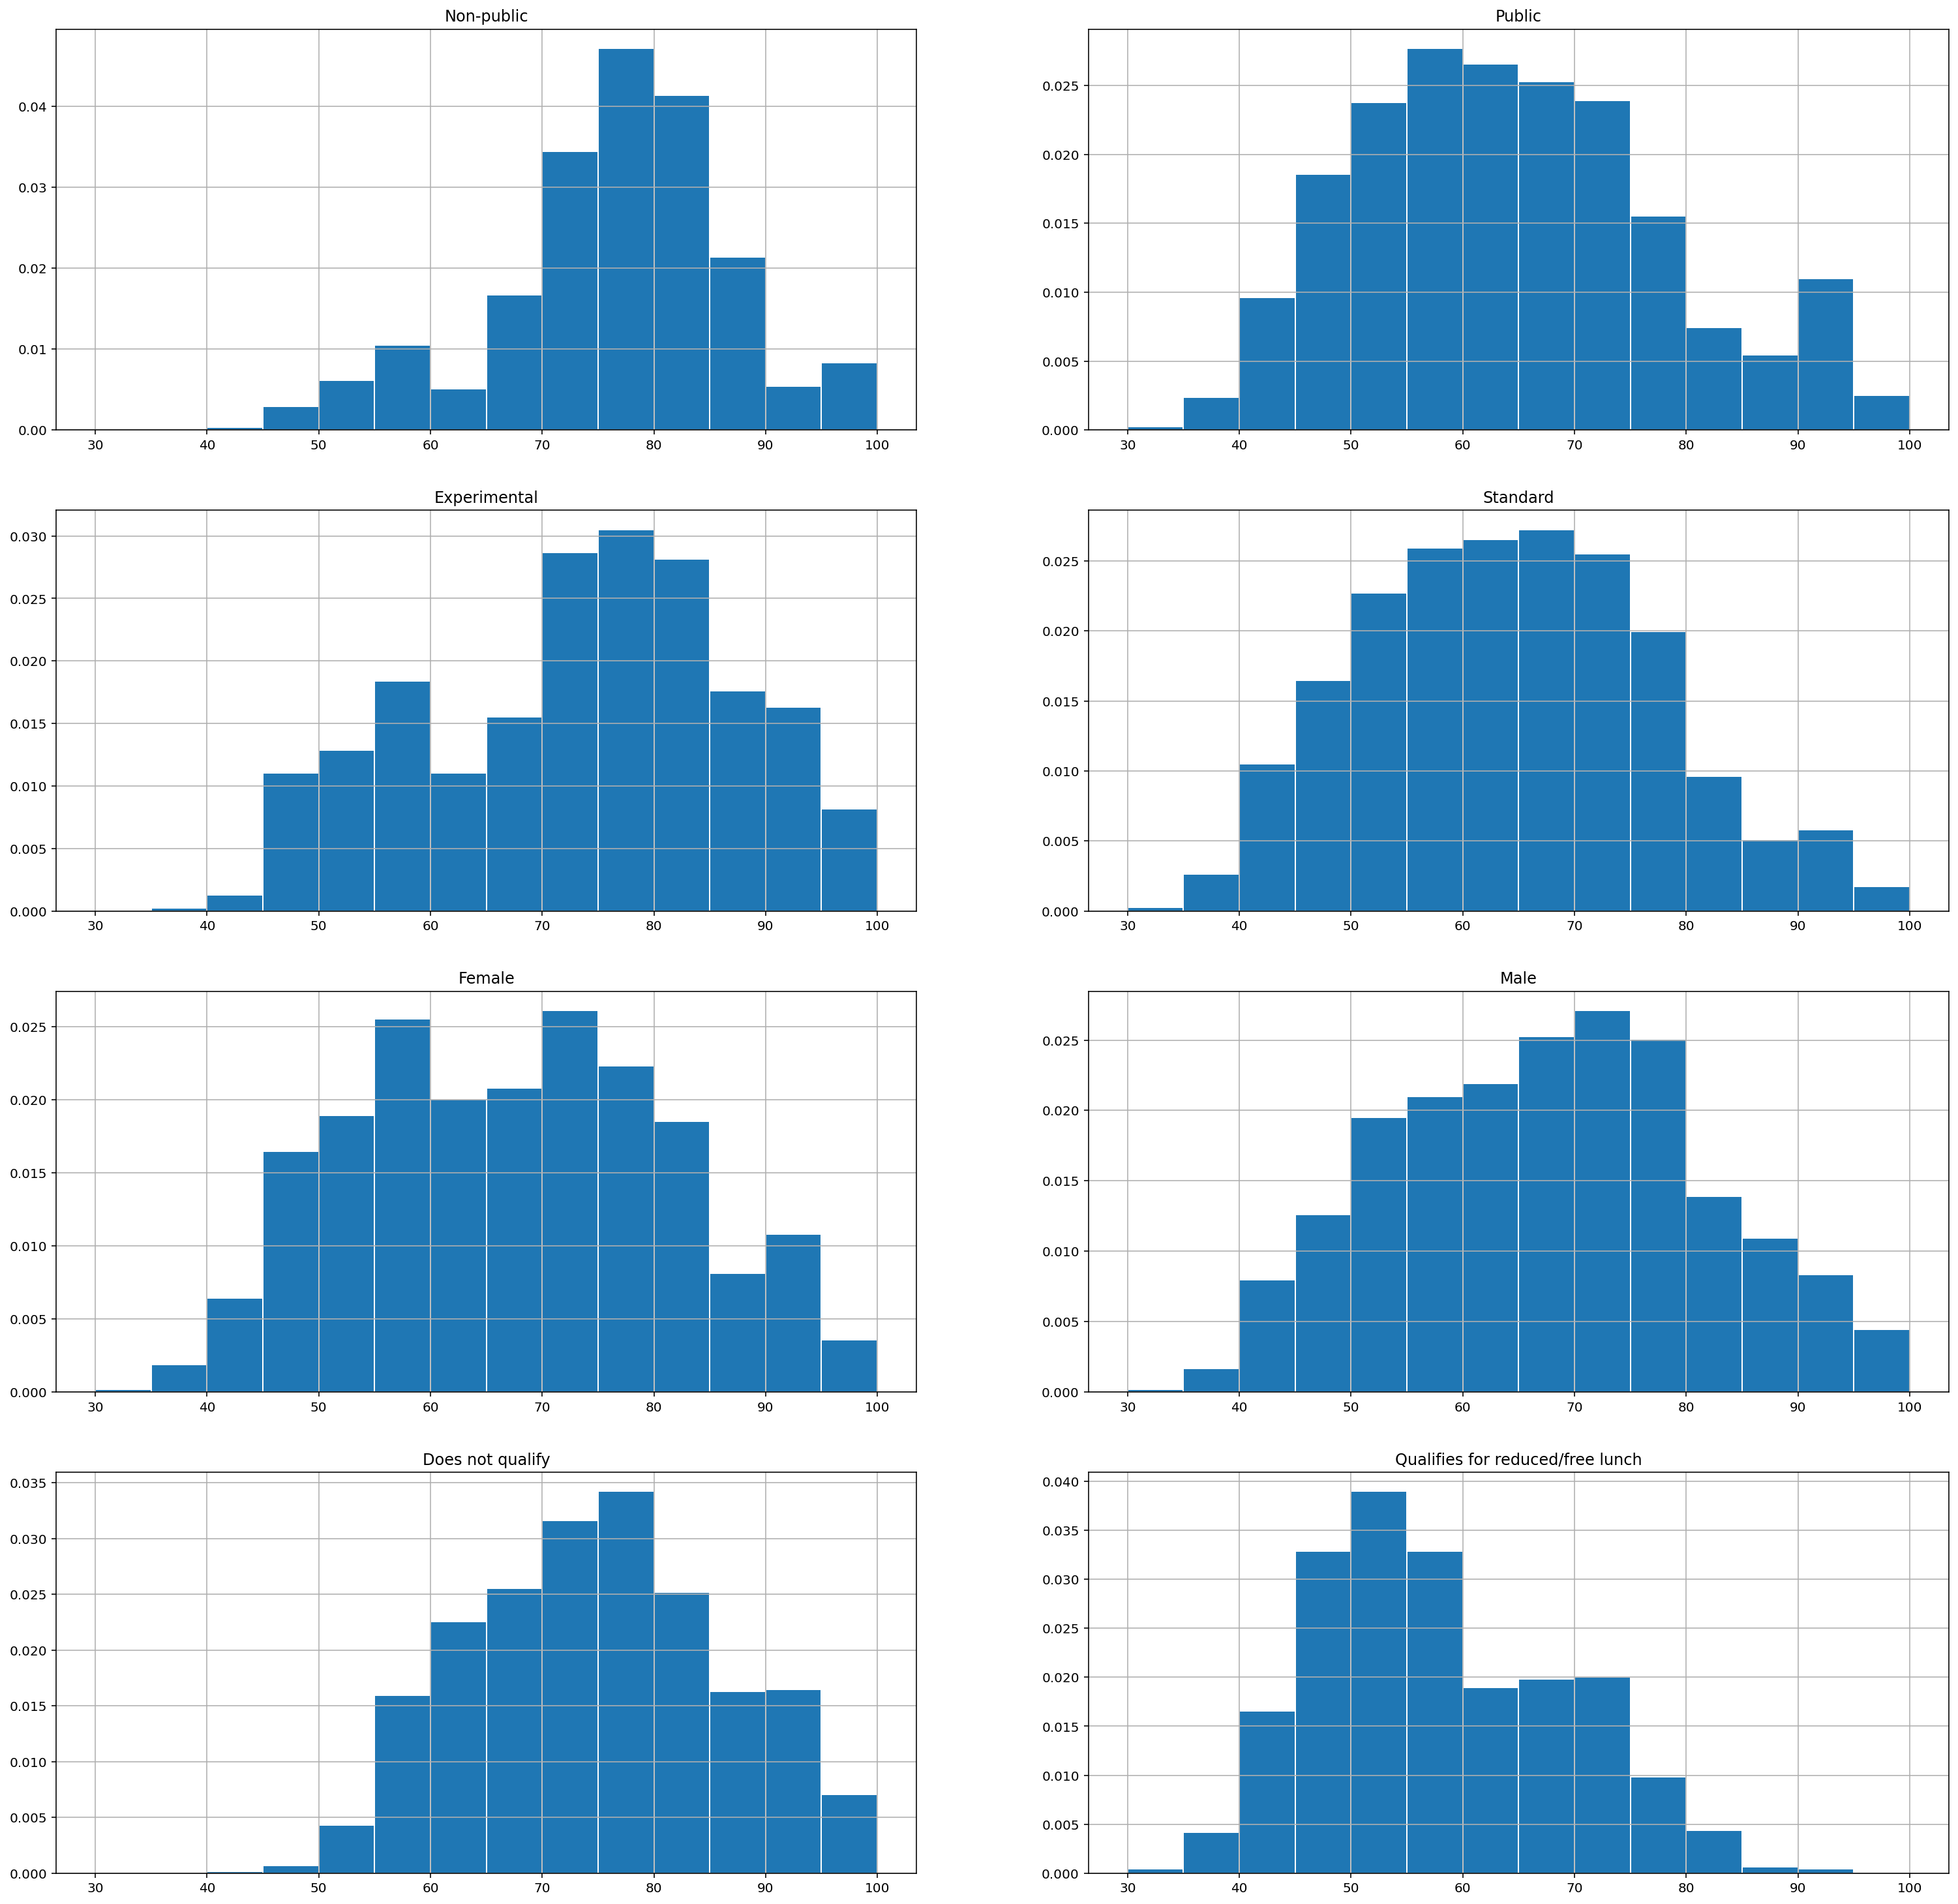

In [23]:
plt.figure(figsize =(26,26))
binary_cols = [col for col in f_data.columns if str(f_data[col].dtype) == 'category' and len(f_data[col].cat.categories)==2 ]
c = 1
print(binary_cols)
for j, col in enumerate(binary_cols):
    cats = f_data[col].cat.categories
    for i in range(len(cats)):
        plt.subplot(len(binary_cols),2,c)
        plt.title(cats[i])
        f_data.loc[f_data[col] == cats[i],'posttest'].hist(edgecolor = 'white',bins = g_bins,density = True)
        c+=1
plt.show()

In [26]:
pd.crosstab(f_data.school_type,f_data.lunch,normalize='index').round(3)*100

lunch,Does not qualify,Qualifies for reduced/free lunch
school_type,,
Non-public,71.3,28.7
Public,52.0,48.0


In [30]:
pd.crosstab(f_data.school_type,f_data.teaching_method,normalize='index').round(3)*100

teaching_method,Experimental,Standard
school_type,,
Non-public,48.1,51.9
Public,31.3,68.7


In [9]:
f_data.groupby("school_type").describe().loc[:,['posttest']]

posttest                                                     
               count       mean        std   min   25%   50%   75%    max
school_type                                                              
Non-public     551.0  75.961887  10.539812  44.0  71.0  77.0  82.0  100.0
Public        1582.0  64.016435  13.721537  32.0  54.0  63.0  73.0   99.0

In [10]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(f_data.binned_grades,f_data.school_type,normalize="columns")*100).round(1)

school_type,Non-public,Public
binned_grades,,
"(30, 35]",0.0,0.2
"(35, 40]",0.0,1.7
"(40, 45]",0.2,5.9
"(45, 50]",1.8,9.7
"(50, 55]",3.6,12.5
"(55, 60]",4.9,13.7
"(60, 65]",2.7,12.8
"(65, 70]",10.5,13.5
"(70, 75]",18.5,10.4


In [11]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(f_data.binned_grades,f_data.teaching_method,normalize="columns")*100).round(1)

teaching_method,Experimental,Standard
binned_grades,,
"(30, 35]",0.0,0.2
"(35, 40]",0.1,1.9
"(40, 45]",1.3,6.1
"(45, 50]",5.9,8.7
"(50, 55]",7.2,11.9
"(55, 60]",8.9,12.8
"(60, 65]",4.6,13.3
"(65, 70]",9.7,14.3
"(70, 75]",13.9,11.7


In [12]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(f_data.binned_grades,f_data.gender,normalize="columns")*100).round(1)

gender,Female,Male
binned_grades,,
"(30, 35]",0.2,0.1
"(35, 40]",1.2,1.3
"(40, 45]",3.9,4.9
"(45, 50]",8.9,6.5
"(50, 55]",10.2,10.2
"(55, 60]",12.2,10.7
"(60, 65]",9.8,10.6
"(65, 70]",11.7,13.6
"(70, 75]",12.3,12.7


In [13]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(f_data.binned_grades,f_data.school_setting,normalize="columns")*100).round(1)

school_setting,Rural,Suburban,Urban
binned_grades,,,
"(30, 35]",0.0,0.0,0.3
"(35, 40]",3.1,0.0,1.2
"(40, 45]",8.0,0.0,5.8
"(45, 50]",3.9,0.6,15.5
"(50, 55]",9.2,2.5,16.9
"(55, 60]",15.1,6.0,13.7
"(60, 65]",8.0,9.1,12.3
"(65, 70]",15.5,14.6,9.6
"(70, 75]",18.8,16.2,6.1


In [14]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(f_data.binned_grades,f_data.lunch,normalize="columns")*100).round(1)

lunch,Does not qualify,Qualifies for reduced/free lunch
binned_grades,,
"(30, 35]",0.0,0.3
"(35, 40]",0.0,2.9
"(40, 45]",0.2,10.0
"(45, 50]",0.4,17.3
"(50, 55]",3.0,19.7
"(55, 60]",9.1,14.5
"(60, 65]",10.9,9.2
"(65, 70]",14.6,10.2
"(70, 75]",15.0,9.3


In [15]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(f_data.binned_grades,pd.cut(f_data.n_student,bins=range(10,36,5)),normalize="columns")*100).round(1)

n_student,"(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]"
binned_grades,,,,,
"(30, 35]",0.0,0.0,0.0,0.5,0.0
"(35, 40]",0.0,0.0,2.1,1.4,0.0
"(40, 45]",0.0,0.0,7.0,5.5,0.0
"(45, 50]",0.0,1.1,7.8,15.7,0.0
"(50, 55]",0.0,5.7,8.5,17.1,41.9
"(55, 60]",0.0,8.8,9.2,16.9,51.6
"(60, 65]",1.4,5.7,7.6,20.1,6.5
"(65, 70]",16.4,10.3,15.1,11.6,0.0
"(70, 75]",26.0,20.0,11.1,6.2,0.0


In [16]:
data = f_data.copy()
categories = dict()
for col in data.columns:
    if str(data[col].dtype) != "category":
        continue
    if len(cats := data[col].cat.categories) == 2:
        categories[col] = {cats[0]:-1,cats[1]:1}
    else:
        categories[col] = {cats[i]:i for i in range(len(cats))}
    data[col] = data[col].apply(lambda x: categories[col][x])
print(categories)
data.head()

{'school_setting': {'Rural': 0, 'Suburban': 1, 'Urban': 2}, 'school_type': {'Non-public': -1, 'Public': 1}, 'teaching_method': {'Experimental': -1, 'Standard': 1}, 'gender': {'Female': -1, 'Male': 1}, 'lunch': {'Does not qualify': -1, 'Qualifies for reduced/free lunch': 1}, 'binned_grades': {Interval(30, 35, closed='right'): 0, Interval(35, 40, closed='right'): 1, Interval(40, 45, closed='right'): 2, Interval(45, 50, closed='right'): 3, Interval(50, 55, closed='right'): 4, Interval(55, 60, closed='right'): 5, Interval(60, 65, closed='right'): 6, Interval(65, 70, closed='right'): 7, Interval(70, 75, closed='right'): 8, Interval(75, 80, closed='right'): 9, Interval(80, 85, closed='right'): 10, Interval(85, 90, closed='right'): 11, Interval(90, 95, closed='right'): 12, Interval(95, 100, closed='right'): 13}}


,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,binned_grades
0,2,-1,1,20.0,-1,-1,62.0,72.0,8
1,2,-1,1,20.0,-1,-1,66.0,79.0,9
2,2,-1,1,20.0,1,-1,64.0,76.0,9
3,2,-1,1,20.0,-1,-1,61.0,77.0,9
4,2,-1,1,20.0,1,-1,64.0,76.0,9


In [17]:
data

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,binned_grades
0,2,-1,1,20.0,-1,-1,62.0,72.0,8
1,2,-1,1,20.0,-1,-1,66.0,79.0,9
2,2,-1,1,20.0,1,-1,64.0,76.0,9
3,2,-1,1,20.0,-1,-1,61.0,77.0,9
4,2,-1,1,20.0,1,-1,64.0,76.0,9
...,...,...,...,...,...,...,...,...,...
2128,2,1,1,30.0,-1,-1,39.0,55.0,4
2129,2,1,1,30.0,-1,1,38.0,46.0,3
2130,2,1,1,30.0,-1,1,45.0,51.0,4
2131,2,1,1,30.0,1,1,46.0,53.0,4


In [40]:

r_data = data.sample(frac=1, random_state=13077, ignore_index=True).drop(columns=["binned_grades"])
# Separa o df em train e test, com teste de 1/3
train, test =(r_data.iloc[:1000].copy(), r_data.iloc[1000:].copy())
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()
tree.fit(train.drop(columns=["posttest"]),train.posttest)
forest.fit(train.drop(columns=["posttest"]),train.posttest)
test["prediction_tree"] = tree.predict(test.drop(columns=["posttest"]))
test["prediction_forest"] = forest.predict(test.drop(columns=["posttest","prediction_tree"]))

test.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,prediction_tree,prediction_forest
1000,1,1,1,27.0,1,1,52.0,65.0,62.75,62.605571
1001,1,1,-1,23.0,-1,-1,79.0,94.0,92.50,93.575833
1002,0,1,1,19.0,-1,-1,62.0,73.0,73.00,72.659000
1003,2,1,-1,24.0,1,-1,53.0,71.0,70.00,69.825619
1004,2,1,1,25.0,-1,1,35.0,52.0,53.00,50.639667


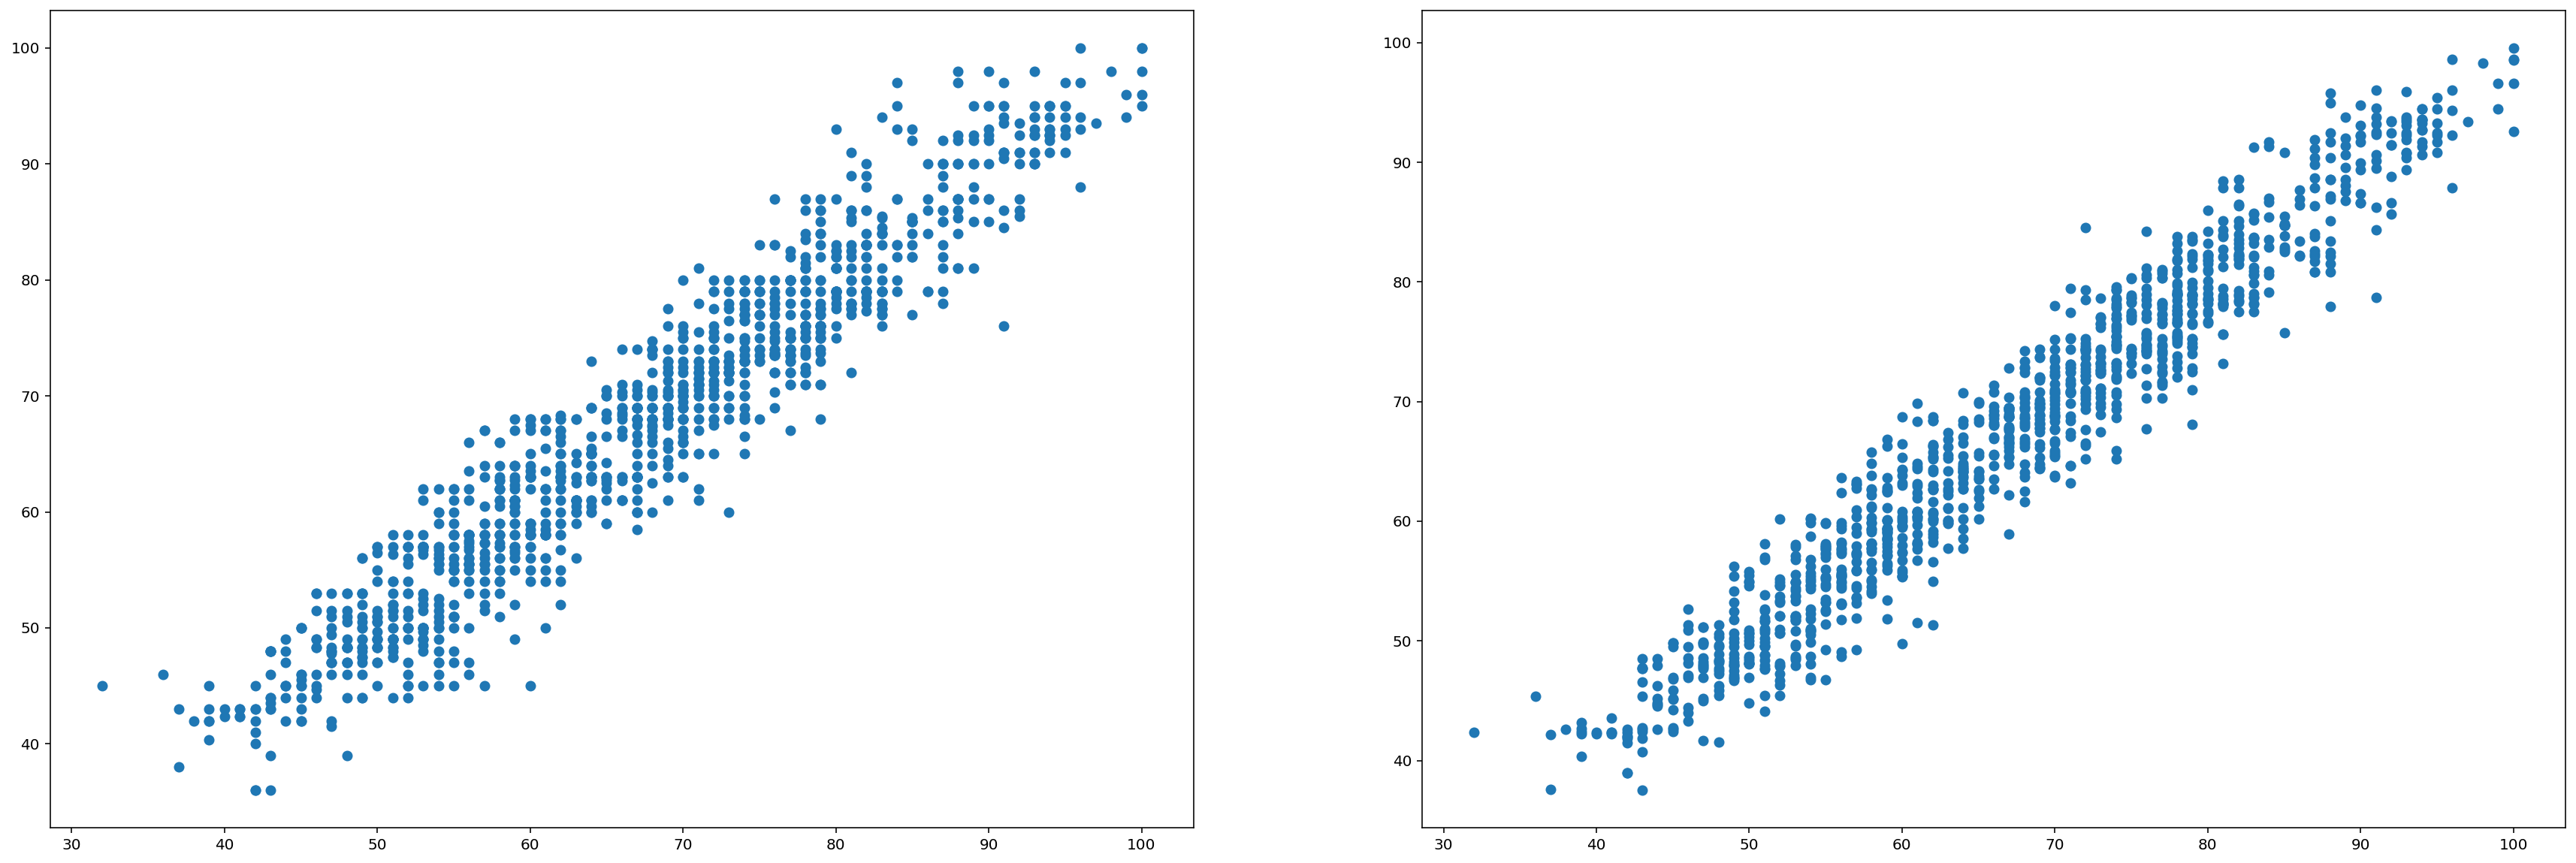

In [42]:
plt.figure(figsize=(30,10))
plt.subplot(121)
plt.scatter(test.posttest,test.prediction_tree)
plt.subplot(122)
plt.scatter(test.posttest,test.prediction_forest)
plt.show()